## Sample QC and population definition exploratory analysis
#### Yosuke Tanigawa (ytanigaw@stanford.edu)
#### 2019/7/26

In [2]:
suppressMessages(require(tidyverse))
suppressMessages(require(data.table))

In [3]:
read_sqc <- function(){
    # This function reads sample QC (sqc) file
    sqc_dir <- '/oak/stanford/groups/mrivas/ukbb24983/sqc/download'
    sqc_cols <- file.path(sqc_dir, 'ukb_sqc_v2.fields.txt') %>% 
    fread(header=F, data.table=F, col.names = 'col') %>% 
    filter(col != '') %>% pull()

    file.path(sqc_dir, 'ukb_sqc_v2.txt') %>% 
    fread(header=F, data.table=F, col.names = sqc_cols)
}

In [4]:
read_fam <- function(){
    # This function reads PLINK fam file
    '/oak/stanford/groups/mrivas/ukbb24983/fam/ukb2498_cal_v2_s488370.fam' %>%
    fread(
        header=F, data.table=F, 
        col.names = c('FID', 'IID', 'father', 'mother', 'sex_code', 'batch')
    ) %>%
    left_join(
        data.frame(
            sex_code = c(1, 2, 0),
            sex = c('male', 'female', 'unknown')
        ),
        by='sex_code'
    )    
}

In [5]:
read_remove <- function(){
    # read list of individuals that should be removed from the analysis
    '/oak/stanford/groups/mrivas/ukbb24983/sqc/w24983_20181016.csv' %>%
    fread(header=F, data.table=F, col.names=c('FID')) %>%
    mutate(IID=FID, in_remove_file=TRUE)    
}

In [6]:
read_self_reported_ethnicity <- function(){
    paste0(
        'cat ',
        '/oak/stanford/groups/mrivas/ukbb24983/phenotypedata/extras/self_reported_ethnicity/phe/ukb9796_ukb24611_f21000.phe',
        ' | sed -e "s/^#//g"'
    ) %>%
    fread(cmd=., header=T, data.table=F)
}


In [7]:
read_coding1001 <- function(){
    df <- '/oak/stanford/groups/mrivas/ukbb24983/phenotypedata/extras/self_reported_ethnicity/misc/coding1001.tsv' %>%
    fread(header=T, data.table=F, sep='\t')    
    
    df %>%
    mutate(parent_id = if_else(parent_id == 0, coding, parent_id)) %>%
    left_join(
        df %>% select(coding, meaning) %>% rename(
            parent_id = coding, parent_label = meaning
        ),
        by='parent_id'
    ) %>% select(-node_id, -selectable, -parent_id) %>%
    rename(
        coding1001 = coding,
        top_label = parent_label,
        sub_label = meaning
    )    
}

In [8]:
read_master_sqc <- function(){
    fam_df <- read_fam()
    sqc_df <- read_sqc()
    remove_df <- read_remove()
    self_reported_ethnicity <- read_self_reported_ethnicity()
    coding1001 <- read_coding1001()
    
    bind_cols(fam_df, sqc_df) %>%
    left_join(remove_df, by=c('FID', 'IID')) %>%
    left_join(self_reported_ethnicity, by=c('FID', 'IID')) %>%
    left_join(coding1001 %>% rename(f21000 = coding1001), by='f21000')
}

In [9]:
master_sqc_df <- read_master_sqc()

In [10]:
master_sqc_df %>% colnames()

[1] "FID"                                "IID"                               
 [3] "father"                             "mother"                            
 [5] "sex_code"                           "batch"                             
 [7] "sex"                                "affymetrix_field_1"                
 [9] "affymetrix_field_2"                 "genotyping_array"                  
[11] "Batch"                              "Plate_Name"                        
[13] "Well"                               "Cluster_CR"                        
[15] "dQC"                                "Internal_Pico_ng_uL"               
[17] "Submitted_Gender"                   "Inferred_Gender"                   
[19] "X_intensity"                        "Y_intensity"                       
[21] "Submitted_Plate_Name"               "Submitted_Well"                    
[23] "sample_qc_missing_rate"             "heterozygosity"                    
[25] "heterozygosity_pc_corrected"        "het_missing_outliers"              
[27] "putative_sex_chromosome_aneuploidy" "in_kinship_table"                  
[29] "excluded_from_kinship_inference"    "excess_relatives"                  
[31] "in_white_British_ancestry_subset"   "used_in_pca_calculation"           
[33] "PC1"                                "PC2"                               
[35] "PC3"                                "PC4"                               
[37] "PC5"                                "PC6"                               
[39] "PC7"                                "PC8"                               
[41] "PC9"                                "PC10"                              
[43] "PC11"                               "PC12"                              
[45] "PC13"                               "PC14"                              
[47] "PC15"                               "PC16"                              
[49] "PC17"                               "PC18"                              
[51] "PC19"                               "PC20"                              
[53] "PC21"                               "PC22"                              
[55] "PC23"                               "PC24"                              
[57] "PC25"                               "PC26"                              
[59] "PC27"                               "PC28"                              
[61] "PC29"                               "PC30"                              
[63] "PC31"                               "PC32"                              
[65] "PC33"                               "PC34"                              
[67] "PC35"                               "PC36"                              
[69] "PC37"                               "PC38"                              
[71] "PC39"                               "PC40"                              
[73] "in_Phasing_Input_chr1_22"           "in_Phasing_Input_chrX"             
[75] "in_Phasing_Input_chrXY"             "in_remove_file"                    
[77] "f21000"                             "sub_label"                         
[79] "top_label"

In [18]:
count.wo.filter <- master_sqc_df %>% count(top_label, sub_label, f21000)

In [13]:
master_sqc_df %>% count(putative_sex_chromosome_aneuploidy)

putative_sex_chromosome_aneuploidy,n
0,487725
1,652


In [14]:
master_sqc_df %>% count(het_missing_outliers)

het_missing_outliers,n
0,487409
1,968


In [15]:
master_sqc_df %>% count(excess_relatives)

excess_relatives,n
0,488189
1,188


In [16]:
master_sqc_df %>% count(used_in_pca_calculation)

used_in_pca_calculation,n
0,81158
1,407219


In [20]:
count.QC <- master_sqc_df %>% 
filter(
    putative_sex_chromosome_aneuploidy == 0,
    het_missing_outliers == 0, 
    excess_relatives == 0
) %>% 
count(top_label, sub_label, f21000) %>%
rename(n_QC = n)

In [26]:
count.QC.PCA <- master_sqc_df %>% 
filter(
    putative_sex_chromosome_aneuploidy == 0,
    het_missing_outliers == 0, 
    excess_relatives == 0,
    used_in_pca_calculation == 1
) %>% 
count(top_label, sub_label, f21000) %>%
rename(n_QC_PCA = n)

In [27]:
count.wo.filter %>%
left_join(
    count.QC %>% select(f21000, n_QC), by='f21000'
)%>%
left_join(
    count.QC.PCA %>% select(f21000, n_QC_PCA), by='f21000'
)

top_label,sub_label,f21000,n,n_QC,n_QC_PCA
NA,NA,NA,1438,1428,1237
Asian or Asian British,Any other Asian background,3004,1733,1733,1629
Asian or Asian British,Asian or Asian British,3,42,41,34
Asian or Asian British,Bangladeshi,3003,221,221,209
Asian or Asian British,Indian,3001,5712,5651,5117
Asian or Asian British,Pakistani,3002,1746,1740,1583
Black or Black British,African,4002,3199,3196,3067
Black or Black British,Any other Black background,4003,116,116,107
Black or Black British,Black or Black British,4,25,25,22
Black or Black British,Caribbean,4001,4295,4286,3790


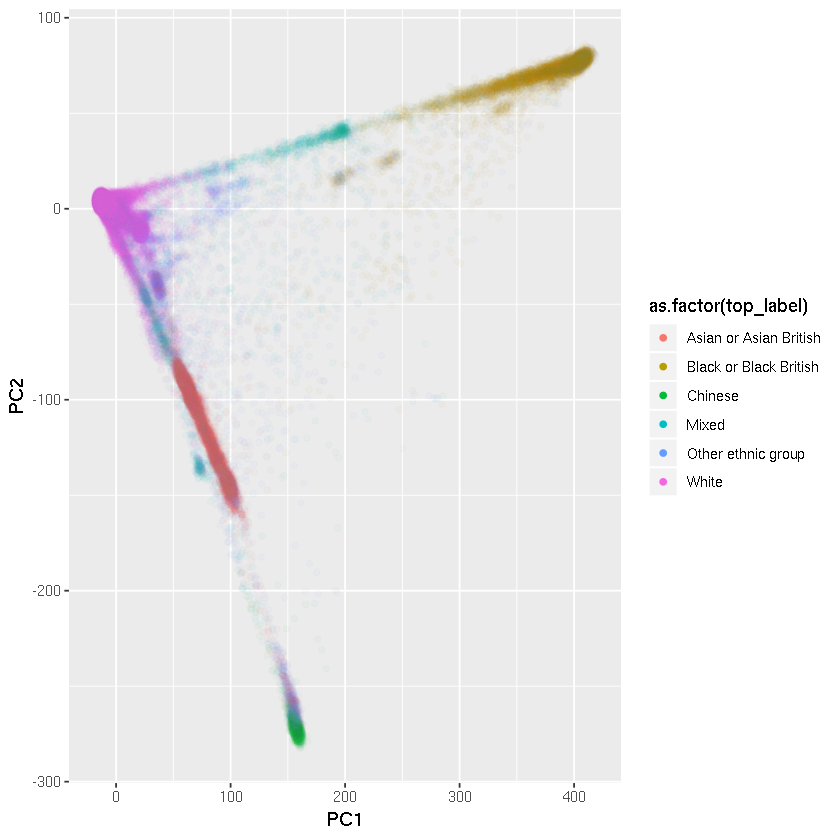

In [122]:
master_sqc_df %>% 
drop_na(f21000) %>%
filter(f21000 != -3, f21000 != -1) %>%
ggplot(aes(x = PC1, y = PC2, color=as.factor(top_label))) +
geom_point(alpha=.025) + 
guides(colour = guide_legend(override.aes = list(alpha = 1)))

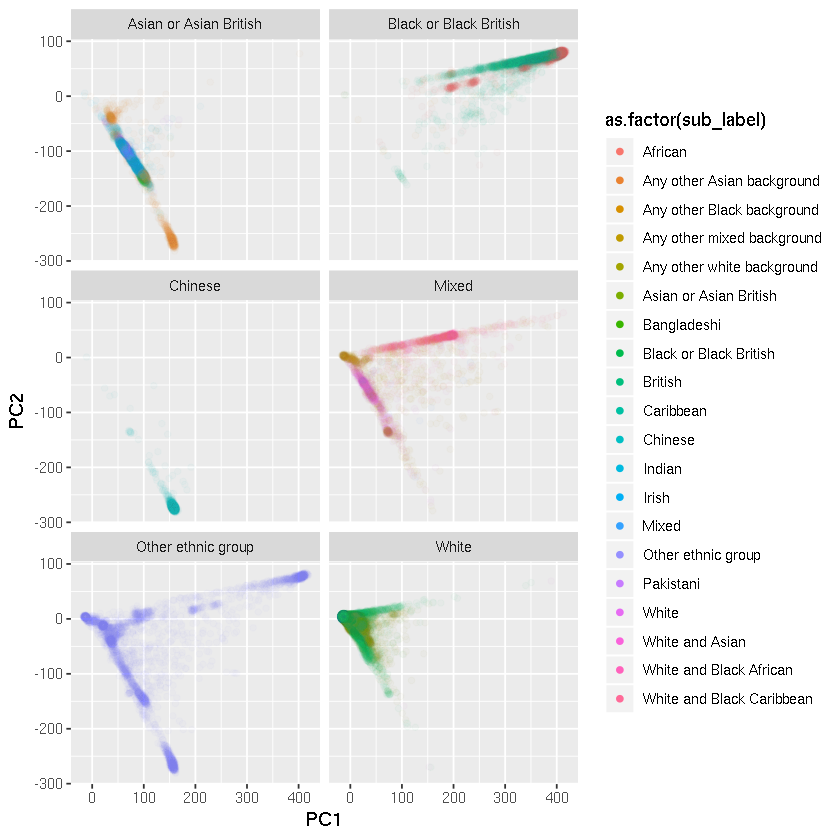

In [118]:
master_sqc_df %>% 
drop_na(f21000) %>%
filter(f21000 != -3, f21000 != -1) %>%
ggplot(aes(x = PC1, y = PC2, color=as.factor(sub_label))) +
geom_point(alpha=.025) + 
facet_wrap( ~ top_label, ncol=2) + 
guides(colour = guide_legend(override.aes = list(alpha = 1)))

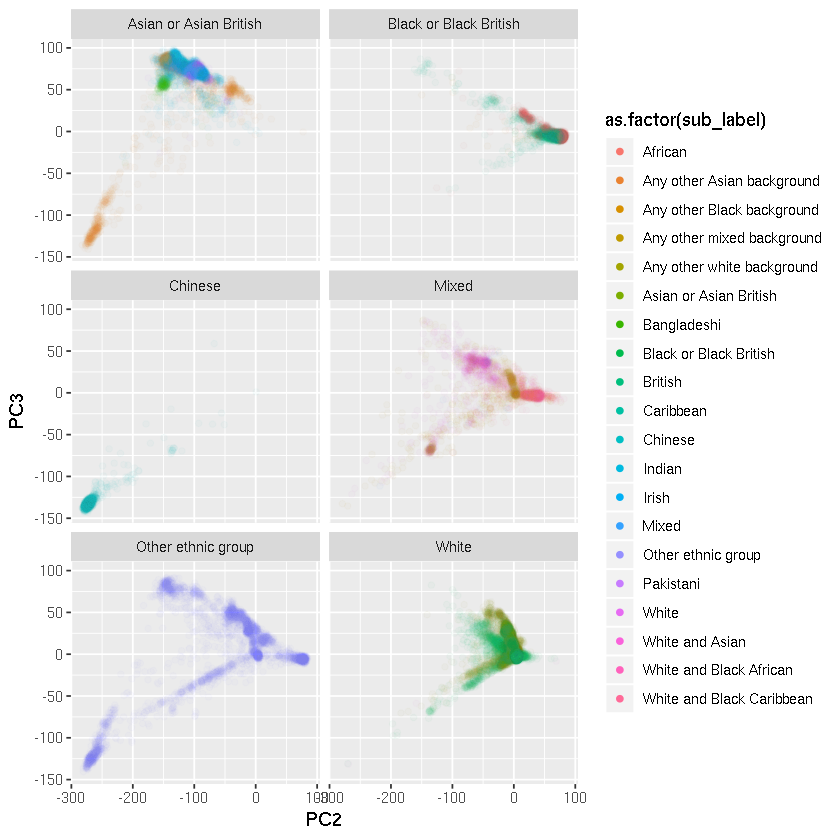

In [119]:
master_sqc_df %>% 
drop_na(f21000) %>%
filter(f21000 != -3, f21000 != -1) %>%
ggplot(aes(x = PC2, y = PC3, color=as.factor(sub_label))) +
geom_point(alpha=.025) + 
facet_wrap( ~ top_label, ncol=2) + 
guides(colour = guide_legend(override.aes = list(alpha = 1)))

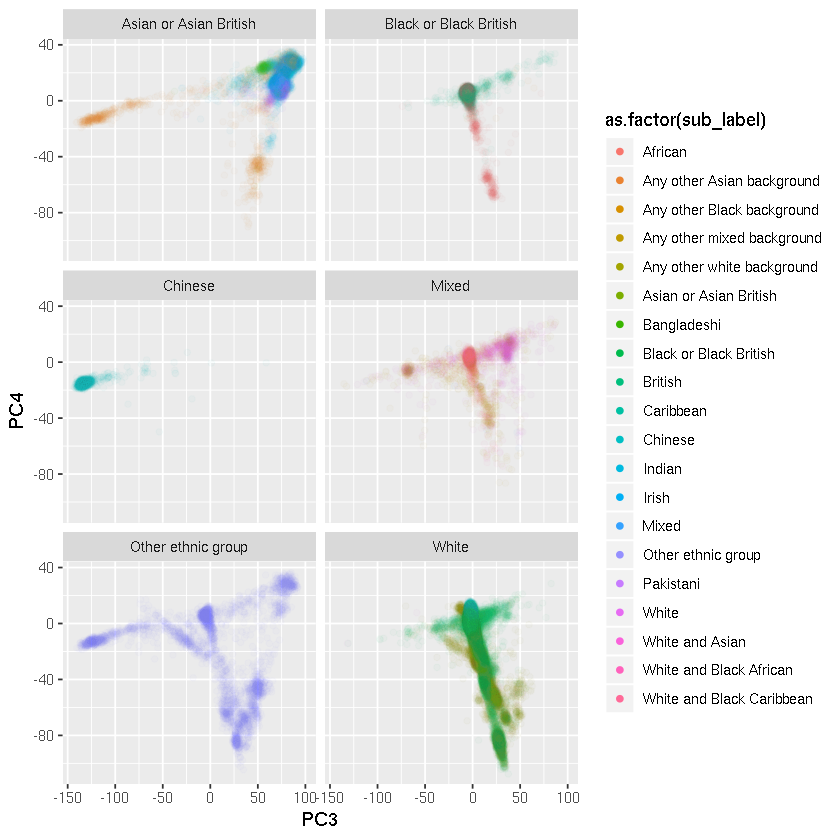

In [120]:
master_sqc_df %>% 
drop_na(f21000) %>%
filter(f21000 != -3, f21000 != -1) %>%
ggplot(aes(x = PC3, y = PC4, color=as.factor(sub_label))) +
geom_point(alpha=.025) + 
facet_wrap( ~ top_label, ncol=2) + 
guides(colour = guide_legend(override.aes = list(alpha = 1)))

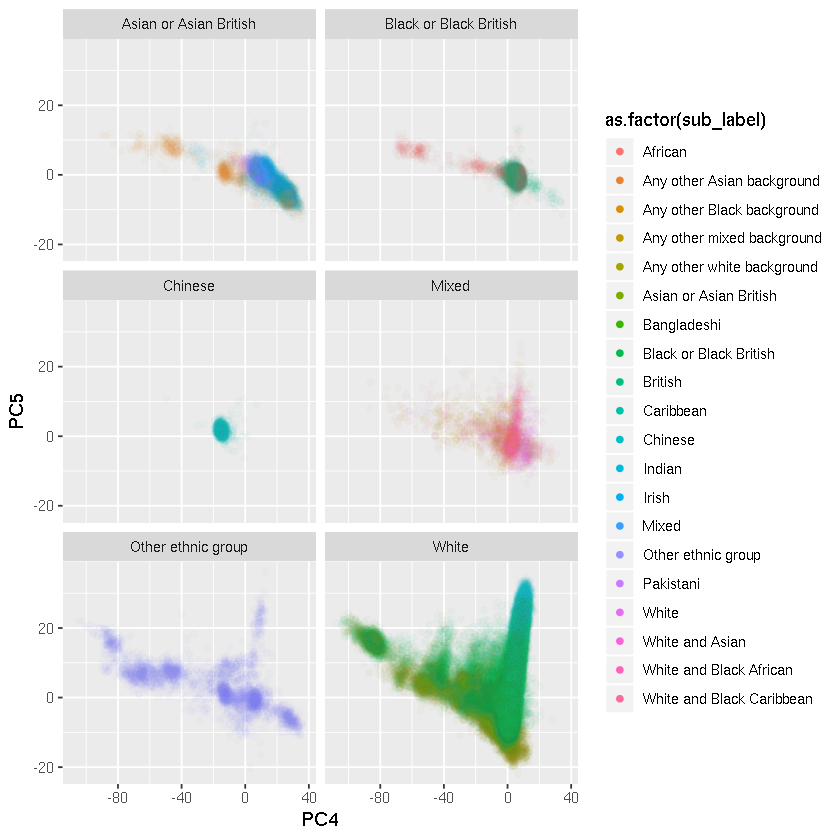

In [121]:
master_sqc_df %>% 
drop_na(f21000) %>%
filter(f21000 != -3, f21000 != -1) %>%
ggplot(aes(x = PC4, y = PC5, color=as.factor(sub_label))) +
geom_point(alpha=.025) + 
facet_wrap( ~ top_label, ncol=2) + 
guides(colour = guide_legend(override.aes = list(alpha = 1)))